<img style="float: right; width: 350px" src="./Data/Logo.png">
# Lending Club - Do market trends influence who defaults and who doesn't? 

**Introduction to Data Science Fall 2018**<br/>
**Group #72:** Hunter Bigge, Phil Lai, Tom Osborn, Ben Skinner

In [87]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [20]:
# Data and Stats packages
import numpy as np
import pandas as pd
import re
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils import shuffle

#Keras and Tensorflow

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import itertools
from collections import OrderedDict

import tensorflow as tf
import keras
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense , Flatten, Dropout
from keras import regularizers


# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 500)
sns.set_style('whitegrid')
sns.set_context('talk')

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Data Processing

In [3]:
#import data

df_07to11 = pd.read_csv('./Data/LoanStats3a.csv',header=1)
df_2016Q1 = pd.read_csv('./Data/LoanStats_2016Q1.csv',header=1)
df_2016Q2 = pd.read_csv('./Data/LoanStats_2016Q2.csv',header=1)
df_2016Q3 = pd.read_csv('./Data/LoanStats_2016Q3.csv',header=1)
df_2016Q4 = pd.read_csv('./Data/LoanStats_2016Q4.csv',header=1)

In [4]:
#concat quarterly dfs for 2016
df_16 = pd.concat([df_2016Q1,df_2016Q2,df_2016Q3,df_2016Q4])

In [5]:
#figure out index when 2007 data begins
not07 = True
i = 0
while(not07):
    val = df_07to11['issue_d'].values[i][-2:]  
    if val == '07':
        print(i)
        not07 = False
    i+=1

39533


In [6]:
df_07 = df_07to11.drop(np.arange(39533))

In [7]:
def clean(df):
    preds = ['loan_status'
         ,'loan_amnt'
         ,'funded_amnt'
         ,'term'
         ,'int_rate'
         ,'installment'
         ,'emp_length'
         ,'home_ownership'
         ,'annual_inc'
         ,'issue_d'
         ,'zip_code'
         ,'addr_state'
         ,'dti'
         ,'delinq_2yrs'
         ,'earliest_cr_line'
         ,'inq_last_6mths'
         ,'mths_since_last_delinq'
         ,'open_acc'
         ,'pub_rec'
         ,'revol_bal'
         ,'revol_util'
         ,'total_acc'
        ]

    states = df['addr_state'].unique().tolist()
    
    df = df[preds]

    df['term'] = df['term'].str.rstrip(' months').astype('float')
    df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0
    df['emp_length'] = df['emp_length'].str.strip('< + years').astype('float')
    df['issue_d'] = pd.to_datetime(df['issue_d'])
    df['zip_code'] = df['zip_code'].str.replace('xx','00').astype('float')
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
    
    df['length_credit_history'] = (df['issue_d']-df['earliest_cr_line']).astype('timedelta64[D]')/30.44
    df['mths_since_last_delinq'] = np.where(df['mths_since_last_delinq'].isna() , df['length_credit_history'], df['mths_since_last_delinq'])
    df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0
    df = pd.get_dummies(df, columns = ['home_ownership'] )
    df = pd.get_dummies(df, columns = ['addr_state'] )
    
    preds.append('length_credit_history')

    df = df.dropna()
    return df

In [8]:
def clean_loan_status (df):
    df['loan_status'] = np.where(df['loan_status'] == 'Fully Paid' , 'paid', df['loan_status'])
    df['loan_status'] = np.where(df['loan_status'] == 'Charged Off' , 'default', df['loan_status'])
    df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'paid', df['loan_status'])
    df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'default', df['loan_status'])
    
    return df

In [9]:
clean_loan_status(df_07)
clean_loan_status(df_16)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,18000.0,18000.0,18000.0,60 months,11.99%,400.31,C,C1,Registered Nurse,6 years,MORTGAGE,100000.00,Verified,Mar-2016,paid,n,NaN,NaN,debt_consolidation,Debt consolidation,986xx,WA,20.41,1.0,Apr-2002,4.0,18.0,NaN,21.0,0.0,29047.0,49%,40.0,w,0.00,0.00,20465.850838,20465.85,18000.00,2465.85,0.00,0.00,0.0000,Jul-2017,14885.49,NaN,Apr-2018,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,299784.0,3.0,1.0,1.0,1.0,4.0,29197.0,92.0,4.0,8.0,7172.0,49.0,58950.0,0.0,1.0,5.0,9.0,16654.0,5072.0,59.0,0.0,0.0,102.0,167.0,0.0,0.0,1.0,9.0,NaN,0.0,18.0,0.0,9.0,16.0,16.0,16.0,6.0,16.0,33.0,11.0,18.0,NaN,0.0,0.0,5.0,98.0,22.2,0.0,0.0,350840.0,58244.0,45650.0,31590.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,8400.0,8400.0,8400.0,36 months,9.75%,270.06,B,B3,RV Tech,2 years,MORTGAGE,66000.00,Not Verified,Mar-2016,paid,n,NaN,NaN,debt_consolidation,Debt consolidation,301xx,GA,13.84,0.0,Jun-2005,1.0,60.0,NaN,7.0,0.0,11059.0,78.4%,22.0,w,0.00,0.00,9449.400972,9449.40,8400.00,1049.40,0.00,0.00,0.0000,Dec-2017,4327.36,NaN,Dec-2017,1.0,60.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,157051.0,1.0,1.0,1.0,1.0,10.0,19231.0,91.0,2.0,2.0,3019.0,86.0,14100.0,1.0,1.0,3.0,4.0,22436.0,585.0,90.6,0.0,0.0,129.0,129.0,2.0,2.0,2.0,89.0,NaN,2.0,NaN,2.0,2.0,4.0,2.0,7.0,2.0,5.0,12.0,4.0,7.0,0.0,0.0,0.0,3.0,86.4,100.0,0.0,0.0,166260.0,30290.0,6200.0,21079.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,28800.0,28800.0,28800.0,36 months,11.99%,956.44,C,C1,RN,10+ years,RENT,120676.15,Source Verified,Mar-2016,paid,n,NaN,NaN,debt_

In [10]:
default_16 = df_16[df_16['loan_status']=='default']
not_default_16 = df_16[df_16['loan_status']=='paid']

default_07 = df_07[df_07['loan_status']=='default']
not_default_07 = df_07[df_07['loan_status']=='paid']

In [11]:
df_16 = pd.concat([default_16, not_default_16])
df_07 = pd.concat([default_07, not_default_07])

In [12]:
df_16.shape, df_07.shape

((238583, 145), (3002, 145))

## Visualization 

### Loan Status vs.Installment 

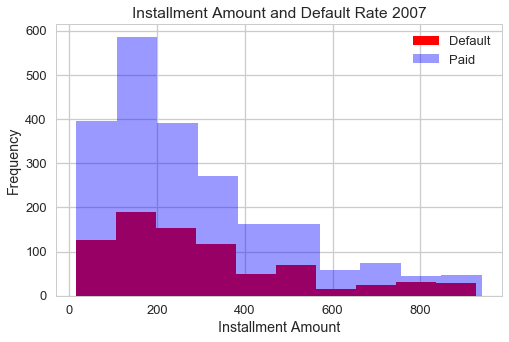

In [31]:
plt.figure(figsize=(8,5))
plt.hist(df_07[df_07['loan_status']=='default']['installment'], label='Default', color='red')
plt.hist(df_07[df_07['loan_status']=='paid']['installment'], label='Paid', color='blue', alpha=0.4)
plt.xlabel("Installment Amount")
plt.ylabel('Frequency')
plt.title("Installment Amount and Default Rate 2007")
plt.legend()
plt.show()

There is no visible relationship between installment amount and default rate in 2007

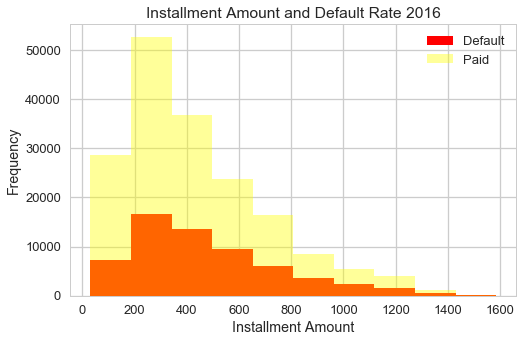

In [32]:
plt.figure(figsize=(8,5))
plt.hist(df_16[df_16['loan_status']=='default']['installment'], label='Default', color='red')
plt.hist(df_16[df_16['loan_status']=='paid']['installment'], label='Paid', color='yellow', alpha=0.4)
plt.xlabel("Installment Amount")
plt.ylabel('Frequency')
plt.title("Installment Amount and Default Rate 2016")
plt.legend()
plt.show()

There is no visible relationship between installment amount and default rate in 2016

### Loan Status vs. Annual Income

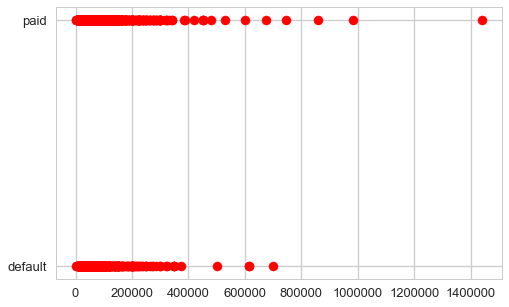

In [33]:
plt.figure(figsize=(8,5))
plt.scatter(df_07['annual_inc'],df_07['loan_status'], color = 'red')
plt.show()

It appears that individuals with higher incomes (>70k) tend to pay their loans in 2007

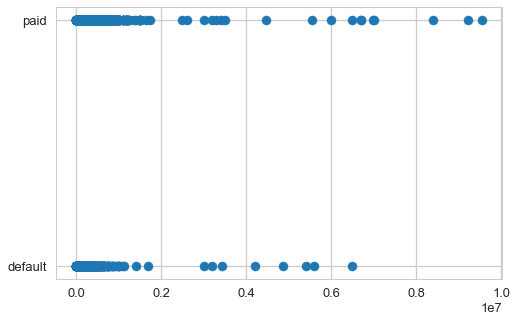

In [34]:
plt.figure(figsize=(8,5))
plt.scatter(df_16['annual_inc'],df_16['loan_status'])
plt.show()

It appears that individuals with higher incomestend to pay their loans in 2016

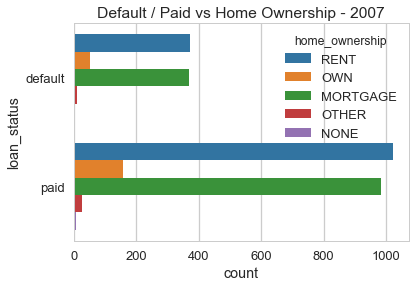

In [36]:
sns.countplot(y='loan_status', hue = 'home_ownership' , data=df_07)
plt.title('Default / Paid vs Home Ownership - 2007')
plt.show()

No reasonable pattern detected

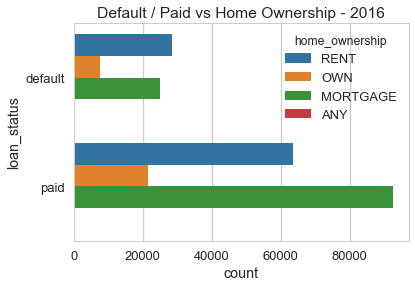

In [18]:
sns.countplot(y='loan_status', hue = 'home_ownership' , data=df_16)
plt.title('Default / Paid vs Home Ownership - 2016')
plt.show()

No reasonable pattern detected

###Understanding distribution of loans by State

In [37]:
by_loan_07 = df_07.groupby(['addr_state'], as_index=False).loan_amnt.sum()
by_loan_16 = df_16.groupby(['addr_state'], as_index=False).loan_amnt.sum()

In [38]:
states_07 = by_loan_07['addr_state'].values.tolist()
loan_per_state_07 = by_loan_07['loan_amnt'].values.tolist()

states_16 = by_loan_16['addr_state'].values.tolist()
loan_per_state_16 = by_loan_16['loan_amnt'].values.tolist()

map_07_data = OrderedDict([('state_codes', states_07),
                          ('state_loans', loan_per_state_07)])

map_16_data = OrderedDict([('state_codes', states_16),
                          ('state_loans', loan_per_state_16)])

map_07 = pd.DataFrame.from_dict(map_07_data)
map_16 = pd.DataFrame.from_dict(map_16_data)

for i in map_07.columns:
    map_07[i]=map_07[i].astype(str)

for i in map_16.columns:
    map_16[i]=map_16[i].astype(str)
    
map_07['txt'] = map_07['state_codes'] + '<br>' + 'Loan Amount: ' + map_07['state_loans']
map_16['txt'] = map_16['state_codes'] + '<br>' + 'Loan Amount: ' + map_16['state_loans']    

In [39]:
#Map of 2007

import plotly.plotly as py
import plotly.graph_objs as go


scl = scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = map_07['state_codes'],
        z = map_07['state_loans'],
        locationmode = 'USA-states',
        text = map_07['txt'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "USD")
        ) ]

layout = dict(
        title = 'Loan Issued per state in 2007 <br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tomleeosborn/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


Most of the loans appear to be distributed around the States in the West Coast and New England in 20007

In [40]:

scl = scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = map_16['state_codes'],
        z = map_16['state_loans'],
        locationmode = 'USA-states',
        text = map_16['txt'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "USD")
        ) ]

layout = dict(
        title = 'Loan Issued per state in 2016 <br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tomleeosborn/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


Most of the loans appear to be distributed around the States in the West Coast and New England in 20007

## Building Models to Predict Loan Default

### Step 1: Data Preprocessing

In [43]:
#clean up all the data 

df_16 = clean(df_16)
df_07 = clean(df_07)

#get rid of colums 
cols_to_remove = ['int_rate', 'issue_d', 'earliest_cr_line', 'zip_code']

df_16 = df_16.drop(cols_to_remove, axis=1)
df_07 = df_07.drop(cols_to_remove, axis=1)

We remove these columns because:
    1. Interest Rate : Lending Club uses interest rate to tell us whether they think a debt will be repaid. For example, the higher the interest rate, the riskier the debt and the higher the chance of default
    2. Issue date: doesn't really help us with anything 
    3. Zip Code : Including it might be considered discriminatory 

In [44]:
df_07['loan_status'] = (pd.Series(np.where(df_07.loan_status == 'default', 0, 1), df_07.index)).values
df_16['loan_status'] = (pd.Series(np.where(df_16.loan_status == 'default', 0, 1), df_16.index)).values

In [47]:
#spliting response variable from the rest
df_07_X = df_07.drop(['loan_status'], axis = 1)
df_07_y = df_07['loan_status']

df_16_X = df_16.drop(['loan_status'], axis = 1)
df_16_y = df_16['loan_status']

In [48]:
#Normalize Data
to_norm = ['loan_amnt', 'funded_amnt', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
           'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
          'total_acc', 'length_credit_history']

In [51]:
from scipy.stats import zscore
def norm(df, cols):
    for e in cols:
        df[e] = zscore(df[e])
    return df

In [52]:
df_07_X = norm (df_07_X, to_norm)
df_16_X = norm (df_16_X, to_norm)

In [53]:
df_07_X.head() #we ready to split

,loan_amnt,funded_amnt,term,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,length_credit_history,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
39536,2.531131,2.627208,36.0,2.687466,0.205262,0.045706,0.798023,-0.323344,-0.617900,-0.871860,-0.361456,-0.29228,-0.243888,-0.287517,-0.745076,-0.724652,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39537,-1.137774,-1.131001,36.0,-1.120983,1.687766,-0.698649,-1.557162,-0.323344,-0.941436,-0.871860,-0.898867,-0.29228,-0.437523,0.135278,-1.034420,-0.783383,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39540,2.531131,2.627208,36.0,2.743268,-0.980741,0.220848,-1.097779,-0.323344,-0.617900,-0.285209,-0.540593,-0.29228,-0.381950,0.807591,-0.745076,0.157079,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39543,-0.021151,0.012802,36.0,0.030733,-0.387740,-0.173222,-1.253617,2.381657,-1.264972,-0.834415,-0.003181,-0.29228,-0.311274,-0.606346,-0.745076,-0.806647,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39546,2.108409,2.194197,36.0,2.268612,-0.980741,0.921417,-1.386418,3.734157,-0.617900,-0.821933,-0.361456,-0.29228,-0.270396,0.013984,-0.528068,0.551417,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
#Train, test data split 
df_07_X_train, df_07_X_test, df_07_y_train, df_07_y_test = train_test_split(df_07_X, df_07_y,
                                                                           test_size = 0.2, random_state = 90)
df_16_X_train, df_16_X_test, df_16_y_train, df_16_y_test = train_test_split(df_16_X, df_16_y,
                                                                           test_size = 0.2, random_state = 90)


### Step 2: Building the Models

#### M0: Trivial Model

We implemented a trivial model that always predicts a given person will repay their loan. It is worth noting that this model is representative of Lending Club's prediction. Since we only have access to accepted loan data, Lending Club is inherently predicting that a loan will be repayed because they wouldn't give a loan that they expected not to be repayed.

In [55]:
#Trivial Model in which all loans are accepted
triv_mod_07_train = np.sum(df_07_y_train)/len(df_07_y_train)
triv_mod_07_test = np.sum(df_07_y_test)/len(df_07_y_test)
print('2007 Data\nTrain score: '+str(triv_mod_07_train))
print('Test score: '+str(triv_mod_07_test))
triv_mod_16_train = np.sum(df_16_y_train)/len(df_16_y_train)
triv_mod_16_test = np.sum(df_16_y_test)/len(df_16_y_test)
print('2016 Data\nTrain score: '+str(triv_mod_16_train))
print('Test score: '+str(triv_mod_16_test))

2007 Data
Train score: 0.7361229718189581
Test score: 0.7133105802047781
2016 Data
Train score: 0.7512421109171479
Test score: 0.7471074010249983


#### M1: Logistic Regression

The first model we chose is a simple logistic regression with cross validation. We trained it on the training set and printed the scores on both the training and test data sets. The test accuracy was 0.737 which is just below our trivial model's score- meaning it performs moderately worse than Lending Club's algorithm.

In [56]:
#Logistic regression on 2007 data
log_mod07 = LogisticRegressionCV().fit(df_07_X_train, df_07_y_train.values)

log_mod07_train_score = log_mod07.score(df_07_X_train,df_07_y_train.values)
log_mod07_test_score =log_mod07.score(df_07_X_test,df_07_y_test.values)
print("The accuracy of Logistic Regression Model on 2007 Training Set is ", log_mod07_train_score)
print("The accuracy of Logistic Regression Model on 2007 Testing Set is ", log_mod07_test_score)

The accuracy of Logistic Regression Model on 2007 Training Set is  0.7361229718189581
The accuracy of Logistic Regression Model on 2007 Testing Set is  0.7133105802047781


In [57]:
#Logistic regression on 2016 data
log_mod16 = LogisticRegressionCV().fit(df_16_X_train, df_16_y_train.values)

log_mod16_train_score = log_mod16.score(df_16_X_train, df_16_y_train.values)
log_mod16_test_score = log_mod16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of Logistic Regression Model on 2016 Training Set is ", log_mod16_train_score)
print("The accuracy of Logistic Regression Model on 2016 Testing Set is ", log_mod16_test_score)

The accuracy of Logistic Regression Model on 2016 Training Set is  0.7573295734300166
The accuracy of Logistic Regression Model on 2016 Testing Set is  0.7533066266812882


#### M2: Decision Tree Model

To create a Decision Tree model, we began by optimizing the tree depth. Our optimal depth was found to be max_depth =i. Depths past i appeared to be overfit, yielding great train accuracies, and poor test accuracies. We then ran the model on both 2007 and 2016 data. The model yielded comparable accuracies to that of Lending Club's.

In [58]:
# Get train score, cross val score means and stds
train_scores = []
cvmeans = []
cvstds = []
depths = list(range(1, 15))
#for all specified maximum tree depths --> fit model and add scores to list
for i in depths:
    #create/fit model
    tree = DecisionTreeClassifier(max_depth = i).fit(df_07_X_train, df_07_y_train.values) 
    train_scores.append(tree.score(df_07_X_train, df_07_y_train.values))
    score = cross_val_score(estimator=tree, X=df_07_X_train, y=df_07_y_train.values, cv=5)
    cvmeans.append(score.mean())
    cvstds.append(score.std())
    
cvstds = np.array(cvstds)
cvmeans = np.array(cvmeans)

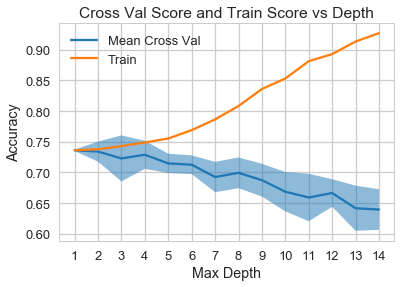

In [59]:
#create plot
plt.plot(depths, cvmeans, label="Mean Cross Val")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.5)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths)
plt.title("Cross Val Score and Train Score vs Depth");

In [60]:
# tree model for 2007 data
tree07 = DecisionTreeClassifier(max_depth = 4).fit(df_07_X_train, df_07_y_train.values)

tree07_train_score = tree07.score(df_07_X_train, df_07_y_train.values)
tree07_test_score = tree07.score(df_07_X_test, df_07_y_test.values)

print("The accuracy of Tree Model on 2007 Training Set is ", tree07_train_score)
print("The accuracy of Tree Model on 2007 Testing Set is ", tree07_test_score)

The accuracy of Tree Model on 2007 Training Set is  0.748932536293766
The accuracy of Tree Model on 2007 Testing Set is  0.7047781569965871


In [61]:
# tree model for 2016 data
tree16 = DecisionTreeClassifier(max_depth = 4).fit(df_16_X_train, df_16_y_train.values)

tree16_train_score = tree16.score(df_16_X_train, df_16_y_train.values)
tree16_test_score = tree16.score(df_16_X_test, df_16_y_test.values)

print("The accuracy of Tree Model on 2016 Training Set is ", tree16_train_score)
print("The accuracy of Tree Model on 2016 Testing Set is ", tree16_test_score)

The accuracy of Tree Model on 2016 Training Set is  0.7532003938946332
The accuracy of Tree Model on 2016 Testing Set is  0.749390148378578


#### M3: Random Forest Model

Next we wanted to create an ensemble model, building off our decision tree model. We stuck with our best max depth of 6, and chose to use 45 trees because it provided solid accuracy, without being too computationally expensive. Our model, again, yielded comparable results ot that of Lending Club.

In [63]:
randy07 = RandomForestClassifier(n_estimators = 45, max_depth = 6).fit(df_07_X_train, df_07_y_train.values)
randy07_train_score = randy07.score(df_07_X_train, df_07_y_train.values)
randy07_test_score = randy07.score(df_07_X_test, df_07_y_test.values)
print("The accuracy of Random Forest Model on 2007 Training Set is ", randy07_train_score)
print("The accuracy of Random Forest Model on 2007 Testing Set is ", randy07_test_score)

The accuracy of Random Forest Model on 2007 Training Set is  0.7395388556789069
The accuracy of Random Forest Model on 2007 Testing Set is  0.7133105802047781


In [64]:
randy16 = RandomForestClassifier(n_estimators = 45, max_depth = 6).fit(df_16_X_train, df_16_y_train.values)
randy16_train_score = randy16.score(df_16_X_train, df_16_y_train.values)
randy16_test_score = randy16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of Random Forest Model on 2016 Training Set is ", randy16_train_score)
print("The accuracy of Random Forest Model on 2016 Testing Set is ", randy16_test_score)

The accuracy of Random Forest Model on 2016 Training Set is  0.7512421109171479
The accuracy of Random Forest Model on 2016 Testing Set is  0.7471074010249983


#### M4: AdaBoost Model

We used an AdaBoost model. This meta estimator fits a decision tree classifier on our training set, then fits additional copies of the model on the same training set, but adjusts weights such that subsequent classifiers focus on challenging cases. For the 2016 dataset, we had to reduce the max depth and estimators to limit the computational time of the model. Both models delivered comparable accuracies to that of Lending Club's model.

In [67]:
ada07 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6), n_estimators=800, learning_rate=0.05).fit(df_07_X_train, df_07_y_train.values)
ada07_train_score = ada07.score(df_07_X_train, df_07_y_train.values)
ada07_test_score = ada07.score(df_07_X_test, df_07_y_test.values)
print("The accuracy of Ada Boost Model on 2007 Training Set is ", ada07_train_score)
print("The accuracy of Ada Boost Model on 2007 Testing Set is ", ada07_test_score)

The accuracy of Ada Boost Model on 2007 Training Set is  1.0
The accuracy of Ada Boost Model on 2007 Testing Set is  0.7030716723549488


In [84]:
#Takes a while to run
ada16 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=80, learning_rate=0.05).fit(df_16_X_train, df_16_y_train.values)
ada16_train_score = ada16.score(df_16_X_train, df_16_y_train.values)
ada16_test_score = ada16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of Ada Boost Model on 2016 Training Set is ", ada16_train_score)
print("The accuracy of Ada Boost Model on 2016 Testing Set is ", ada16_test_score)

The accuracy of Ada Boost Model on 2016 Training Set is  0.7542746519851394
The accuracy of Ada Boost Model on 2016 Testing Set is  0.7508896000716156


#### M5: GradientBoostingClassifier

We used Gradient Boosting (GB) for classification. GB is an additive model in a forward stage-wise fashion. It allows for the optimization of arbitrary differentiable loss functions. In our case we only used a single regression tree because we are interested in a binary classification. This model did decently well on 2016 data


In [70]:
GB_07 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                 max_depth=1, random_state=90).fit(df_07_X_train, df_07_y_train)
GB_07_train_score = GB_07.score(df_07_X_train, df_07_y_train)
GB_07_test_score = GB_07.score(df_07_X_test, df_07_y_test)

print("The accuracy of Gradient Boost Model on 2007 Training Set is ", GB_07_train_score)
print("The accuracy of Gradient Boost Model on 2007 Testing Set is ", GB_07_test_score)

The accuracy of Gradient Boost Model on 2007 Training Set is  0.7745516652433817
The accuracy of Gradient Boost Model on 2007 Testing Set is  0.6911262798634812


In [71]:
GB_16 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                 max_depth=1, random_state=90).fit(df_16_X_train, df_16_y_train)
GB_16_train_score = GB_16.score(df_16_X_train, df_16_y_train)
GB_16_test_score = GB_16.score(df_16_X_test, df_16_y_test)

print("The accuracy of Gradient Boost Model on 2016 Training Set is ", GB_16_train_score)
print("The accuracy of Gradient Boost Model on 2016 Testing Set is ", GB_16_test_score)

The accuracy of Gradient Boost Model on 2016 Training Set is  0.7568595855154201
The accuracy of Gradient Boost Model on 2016 Testing Set is  0.752791889532932


#### M6: LDA Model

Finally, we chose to use linear discriminant analysis. Unsurprisingly, our LDA models performed similarly to the trivial models.

In [72]:
#Build an LDA Model and report train and test accuracy
lda07 = LinearDiscriminantAnalysis().fit(df_07_X_train, df_07_y_train.values)
lda07_train_score = lda07.score(df_07_X_train, df_07_y_train.values)
lda07_test_score = lda07.score(df_07_X_test, df_07_y_test.values)
print("The accuracy of LDA Model on 2007 Training Set is ", lda07_train_score)
print("The accuracy of LDA Model on 2007 Testing Set is ", lda07_test_score)

The accuracy of LDA Model on 2007 Training Set is  0.7382578992314262
The accuracy of LDA Model on 2007 Testing Set is  0.7201365187713311


In [73]:
#Build an LDA Model and report train and test accuracy
lda16 = LinearDiscriminantAnalysis().fit(df_16_X_train, df_16_y_train.values)
lda16_train_score = lda16.score(df_16_X_train, df_16_y_train.values)
lda16_test_score = lda16.score(df_16_X_test, df_16_y_test.values)
print("The accuracy of LDA Model on 2016 Training Set is ", lda16_train_score)
print("The accuracy of LDA Model on 2016 Testing Set is ", lda16_test_score)

The accuracy of LDA Model on 2016 Training Set is  0.7560818674186474
The accuracy of LDA Model on 2016 Testing Set is  0.7532171071772262


#### M7: QDA Model

e were suprises that this model performs extremely poorly. It assumes gaussian distribution and differing covariance, which seemingly contibutes to its poor performance with these datasets.

In [74]:
qda07 = QuadraticDiscriminantAnalysis().fit(df_07_X_train, df_07_y_train.values)

qda07_train_score = qda07.score(df_07_X_train, df_07_y_train.values)
qda07_test_score = qda07.score(df_07_X_test, df_07_y_test.values)

print("The accuracy of QDA Model on Training Set is ", qda07_train_score)
print("The accuracy of QDA Model on Testing Set is ", qda07_test_score)

The accuracy of QDA Model on Training Set is  0.27156276686592656
The accuracy of QDA Model on Testing Set is  0.28668941979522183


In [75]:
qda16 = QuadraticDiscriminantAnalysis().fit(df_16_X_train, df_16_y_train.values)

qda16_train_score = qda16.score(df_16_X_train, df_16_y_train.values)
qda16_test_score = qda16.score(df_16_X_test, df_16_y_test.values)

print("The accuracy of QDA Model on Training Set is ", qda16_train_score)
print("The accuracy of QDA Model on Testing Set is ", qda16_test_score)

The accuracy of QDA Model on Training Set is  0.7445783536994763
The accuracy of QDA Model on Testing Set is  0.7400129803280889


#### M8: Artificial Neural Network

We used Keras resting on Tensorflow to build a neural network for both datasets. 

In [77]:
# 2007 NN

H = 100
input_dim_07 = 71

NN_07 = Sequential()

NN_07.add(Dense(H, input_dim = input_dim_07, activation='relu'))
NN_07.add(Dropout(0.5))

for i in range(1,4):
    NN_07.add(Dense(H, activation='relu'))
    NN_07.add(Dropout(0.2))

NN_07.add(Dense(1, activation='sigmoid'))

NN_07.compile(loss='binary_crossentropy',
          optimizer = 'rmsprop',
          metrics = ['accuracy'])

NN_07.fit(df_07_X_train, df_07_y_train,
      epochs = 50,
      batch_size = 128, verbose = 0)


In [79]:
nn_07_train_accuracy = accuracy_score(NN_07.predict_classes(df_07_X_train), df_07_y_train)
nn_07_test_accuracy = accuracy_score(NN_07.predict_classes(df_07_X_test), df_07_y_test)

print("The accuracy of Neural Network  on  2007 Training Set is ", nn_07_train_accuracy)
print("The accuracy of Neural Network  on  2007 Testing Set is ", nn_07_test_accuracy)

The accuracy of Neural Network  on  2007 Training Set is  0.7361229718189581
The accuracy of Neural Network  on  2007 Testing Set is  0.7133105802047781


In [80]:
#2016 NN
H = 100
input_dim_16 = 70

NN_16 = Sequential()

NN_16.add(Dense(H, input_dim = input_dim_16, activation='relu'))
for i in range(1,10):
    NN_16.add(Dense(H, activation='relu'))
    NN_16.add(Dropout(0.2))

NN_16.add(Dense(1, activation='sigmoid'))

NN_16.compile(loss='binary_crossentropy',
          optimizer = RMSprop(),
          metrics = ['accuracy'])

NN_16.fit(df_16_X_train, df_16_y_train,
      epochs = 20,
      batch_size = 128, verbose =0)


In [81]:
nn_16_train_accuracy = accuracy_score(NN_16.predict_classes(df_16_X_train), df_16_y_train)
nn_16_test_accuracy = accuracy_score(NN_16.predict_classes(df_16_X_test), df_16_y_test)

print("The accuracy of Neural Network  on  2016 Training Set is ", nn_07_train_accuracy)
print("The accuracy of Neural Network  on  2016  Testing Set is ", nn_07_test_accuracy)

The accuracy of Neural Network  on  2016 Training Set is  0.7361229718189581
The accuracy of Neural Network  on  2016  Testing Set is  0.7133105802047781


##### Discussions can be found on the report 

# The End